In [1]:
from elasticsearch import Elasticsearch
from collections import Counter
import pandas as pd
import pyupset as pyu

%matplotlib inline

In [2]:
es = Elasticsearch()
es

<Elasticsearch([{}])>

In [4]:
res = es.search(index="g2p", size=10000, body={"query": {"match_all": {}}})

In [5]:
def collect_all_results():
    res = es.search(index="g2p", size=10000, body={"query": {"match_all": {}}}, scroll='1m')
    scroll_id = res.get('_scroll_id')
    i = 1
    while scroll_id is not None:
        print('Processing scroll {}'.format(i))
        r = es.scroll(scroll_id)
        scroll_id = r.get('_scroll_id')
        res['hits']['hits'] += r['hits']['hits']
        i += 1
    return res
        

In [6]:
res = collect_all_results()

Processing scroll 1


# Total Associations

In [7]:
assert len(res['hits']['hits']) == res['hits']['total']
len(res['hits']['hits'])

11634

In [8]:
def count_attribute(result, attribute):
    c = Counter([x['_source'][attribute] for x in result['hits']['hits']])
    return c

def count_attribute_by_group(result, attribute, group):
    d = dict()
    for g in count_attribute(result, group):
        d[g] = Counter([x['_source'][attribute] for x in result['hits']['hits'] if x['_source'][group] == g])
    return d

def count_list_attribute(result, list_attribute):
    c = Counter([attribute for x in result['hits']['hits'] for attribute in x['_source'][list_attribute]])
    return c

def count_list_attribute_by_group(result, list_attribute, group):
    d = dict()
    for g in count_attribute(result, group):
        d[g] = Counter([attribute for x in result['hits']['hits'] for attribute in x['_source'][list_attribute] if x['_source'][group] == g])
    return d

In [9]:
count_attribute(res, 'source')

Counter({'cgi': 1429, 'civic': 2713, 'jax': 6513, 'oncokb': 373, 'pmkb': 606})

# Genes

In [10]:
count_list_attribute(res, 'genes')

Counter({'ABCB1': 5,
         'ABCC10': 1,
         'ABCC3': 1,
         'ABCG2': 1,
         'ABL1': 385,
         'ACTA1': 1,
         'AFF1': 4,
         'AGR2': 1,
         'AHCYL1': 2,
         'AKT1': 66,
         'AKT2': 3,
         'AKT3': 4,
         'ALCAM': 1,
         'ALDH1A2': 3,
         'ALK': 1020,
         'ANXA1': 2,
         'APC': 99,
         'AR': 22,
         'ARAF': 8,
         'AREG': 7,
         'ARID1A': 4,
         'ASNS': 1,
         'ASXL1': 13,
         'ATM': 52,
         'ATR': 4,
         'ATRX': 8,
         'AURKA': 8,
         'AXL': 1,
         'B2M': 2,
         'B4GALT1': 1,
         'BAIAP2L1': 8,
         'BAP1': 12,
         'BCL': 1,
         'BCL2': 4,
         'BCL2L11': 2,
         'BCL6': 1,
         'BCOR': 4,
         'BCORL1': 1,
         'BICC1': 3,
         'BIRC3': 1,
         'BIRC5': 2,
         'BIRC7': 1,
         'BRAF': 1340,
         'BRCA1': 88,
         'BRCA2': 77,
         'BRD4': 1,
         'BTK': 4,
         'C15orf55'

In [140]:
d = count_list_attribute_by_group(res, 'genes', 'source')

CGI has some genotype "genes" (e.g. 'ARID1A;ANXA1' from ARID1A amplification + ANXA1 overexpression)

CKB have some multi-gene molecular profiles. Example: https://ckb.jax.org/molecularProfile/show/26172

In [12]:
multi_gene_hits = [x for x in res['hits']['hits'] if len(x['_source']['genes']) >= 2]
s = Counter([x['_source']['source'] for x in multi_gene_hits])
s

Counter({'cgi': 45, 'jax': 2492})

In [13]:
mp_d = dict()
for source in s:
    mp_d[source] = set([tuple(sorted(x['_source']['genes'])) for x in res['hits']['hits'] if (len(x['_source']['genes']) >= 2) and (x['_source']['source'] == source)])

In [14]:
mp_d

{'cgi': {('ABL1', 'PRKCH'),
  ('ANXA1', 'ARID1A'),
  ('AR', 'AR'),
  ('ATM', 'RAD50'),
  ('BRAF', 'EGFR'),
  ('BRAF', 'MAP2K1'),
  ('BRAF', 'MET'),
  ('BRAF', 'NF1'),
  ('BRAF', 'PTEN'),
  ('BRAF', 'RAC1'),
  ('BRAF', 'RAF1'),
  ('CDK4', 'RB1'),
  ('EGFR', 'MET'),
  ('EGFR', 'NF2'),
  ('ERBB2', 'ESR1'),
  ('ERBB2', 'HGF'),
  ('ERBB2', 'MET'),
  ('ERBB2', 'PIK3CA'),
  ('ERBB2', 'PTEN'),
  ('G6PD', 'G6PD'),
  ('IL7R', 'SH2B3'),
  ('KRAS', 'STK11')},
 'jax': {('AFF1', 'KMT2A'),
  ('AHCYL1', 'FGFR2'),
  ('AKT1', 'BRAF', 'KRAS'),
  ('AKT1', 'BRAF', 'PTEN'),
  ('AKT1', 'FGFR3'),
  ('AKT1', 'NRAS'),
  ('AKT1', 'PIK3CA'),
  ('ALK', 'EML4'),
  ('ALK', 'EML4', 'SRC'),
  ('ALK', 'ETV6'),
  ('ALK', 'MAP2K1'),
  ('ALK', 'NPM1'),
  ('ALK', 'RB1', 'TP53'),
  ('ALK', 'ROS1'),
  ('ALK', 'SRC'),
  ('ALK', 'TP53'),
  ('APC', 'BRAF', 'ERBB2'),
  ('APC', 'BRAF', 'PIK3CA', 'SMAD4', 'TP53'),
  ('APC', 'CTNNB1'),
  ('APC', 'KDR', 'KRAS'),
  ('APC', 'KRAS'),
  ('APC', 'KRAS', 'PTEN'),
  ('APC', 'PTEN'),
  ('AS

In [16]:
def overlap(group_counts):
    columns = sorted(group_counts) + ['Total']
    sets = {g: set(group_counts[g]) for g in group_counts}
    for g in sets:
        total = set()
        for s in sets:
            l = len(sets[g])
            if s != g:
                o = (sets[g] & sets[s])
                total |= sets[s]
            else:
                continue
            print('{} has {}/{} ({:.2f}%) overlap with {}'.format(g, len(o), l, len(o) / l * 100, s))
        o = (sets[g] & total)
        print('{} has {}/{} ({:.2f}%) overlap overall'.format(g, len(o), l, len(o) / l * 100, s))

In [17]:
overlap(d)

cgi has 59/181 (32.60%) overlap with jax
cgi has 121/181 (66.85%) overlap with civic
cgi has 42/181 (23.20%) overlap with oncokb
cgi has 37/181 (20.44%) overlap with pmkb
cgi has 126/181 (69.61%) overlap overall
jax has 59/106 (55.66%) overlap with cgi
jax has 73/106 (68.87%) overlap with civic
jax has 30/106 (28.30%) overlap with oncokb
jax has 37/106 (34.91%) overlap with pmkb
jax has 78/106 (73.58%) overlap overall
civic has 121/290 (41.72%) overlap with cgi
civic has 73/290 (25.17%) overlap with jax
civic has 42/290 (14.48%) overlap with oncokb
civic has 38/290 (13.10%) overlap with pmkb
civic has 139/290 (47.93%) overlap overall
oncokb has 42/43 (97.67%) overlap with cgi
oncokb has 30/43 (69.77%) overlap with jax
oncokb has 42/43 (97.67%) overlap with civic
oncokb has 20/43 (46.51%) overlap with pmkb
oncokb has 43/43 (100.00%) overlap overall
pmkb has 37/42 (88.10%) overlap with cgi
pmkb has 37/42 (88.10%) overlap with jax
pmkb has 38/42 (90.48%) overlap with civic
pmkb has 20/42 

In [138]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g].keys()), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = ['attribute'])

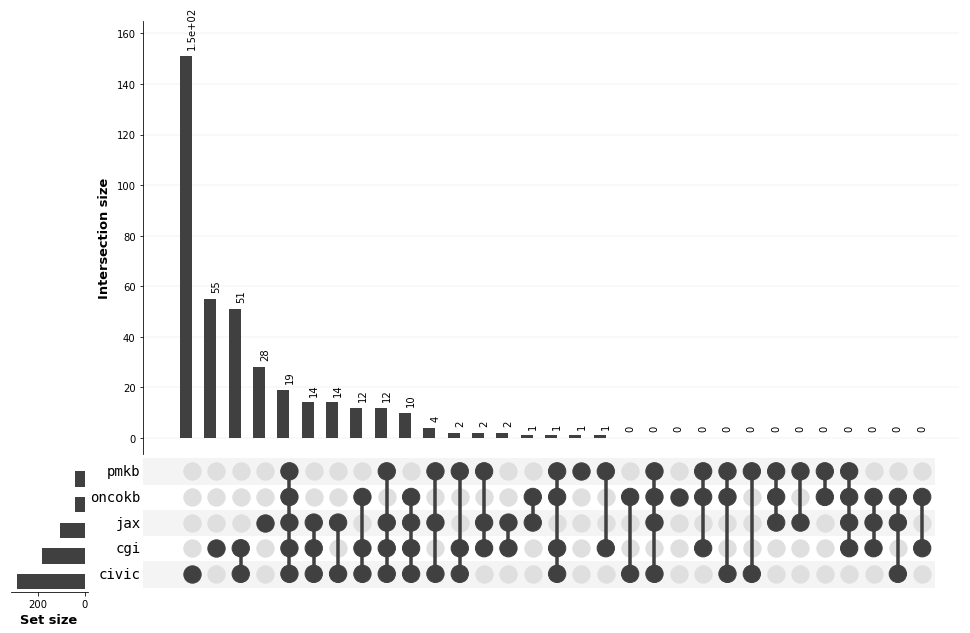

In [141]:
plot_overlap(d)

# Overlap of associations (drug + gene + phenotype)

Some hits (example here is from CGI) have strange behavior on drug normalization:

In [20]:
res['hits']['hits'][0]['_source']['association']['environmentalContexts']

[{'description': 'Imatinib',
  'id': 'compound:CID5291',
  'term': 'Imatinib',
  'toxicity': 'The most frequently reported adverse reactions (>30%) were edema, nausea,\r\nvomiting, muscle cramps, musculoskeletal pain, diarrhea, rash, fatigue and\r\nabdominal pain.'},
 {'description': 'inhibitor',
  'id': 'compound:CID657356',
  'term': 'inhibitor',
  'toxicity': 'unknown'},
 {'description': 'Clorazepate Dipotassium',
  'id': 'compound:CID23706210',
  'term': 'Clorazepate Dipotassium',
  'toxicity': 'unknown'}]

"Inhibitor" drug: https://pubchem.ncbi.nlm.nih.gov/compound/diacylglycerol_kinase_inhibitor_ii#section=Top

In [21]:
res['hits']['hits'][0]['_source']['cgi']

{'Alteration': 'ABL1:I242T,M244V,K247R,L248V,G250E,G250R,Q252R,Q252H,Y253F,Y253H,E255K,E255V,M237V,E258D,W261L,L273M,E275K,E275Q,D276G,T277A,E279K,V280A,V289A,V289I,E292V,E292Q,I293V,L298V,V299L,F311L,F311I,T315I,F317L,F317V,F317I,F317C,Y320C,L324Q,Y342H,M343T,A344V,A350V,M351T,E355D,E355G,E355A,F359V,F359I,F359C,F359L,D363Y,L364I,A365V,A366G,L370P,V371A,E373K,V379I,A380T,F382L,L384M,L387M,L387F,L387V,M388L,Y393C,H396P,H396R,H396A,A397P,S417F,S417Y,I418S,I418V,A433T,S438C,E450K,E450G,E450A,E450V,E453K,E453G,E453A,E453V,E459K,E459G,E459A,E459V,M472I,P480L,F486S,E507G',
 'Alteration type': 'MUT',
 'Assay type': '',
 'Association': 'Resistant',
 'Biomarker': 'ABL1 (I242T,M244V,K247R,L248V,G250E,G250R,Q252R,Q252H,Y253F,Y253H,E255K,E255V,M237V,E258D,W261L,L273M,E275K,E275Q,D276G,T277A,E279K,V280A,V289A,V289I,E292V,E292Q,I293V,L298V,V299L,F311L,F311I,T315I,F317L,F317V,F317I,F317C,Y320C,L324Q,Y342H,M343T,A344V,A350V,M351T,E355D,E355G,E355A,F359V,F359I,F359C,F359L,D363Y,L364I,A365V,A366G,L370P

In [97]:
def select_failures(hits):
    pheno_failed = 0
    drug_failed = 0
    for hit in hits:
        gene = '|'.join(sorted(hit['_source']['genes']))
        try:
            drug = '|'.join(sorted([x['id'] for x in hit['_source']['association']['environmentalContexts']]))
        except:
            print( "Drug failure on ID {}".format( hit['_id'] ))
            drug_failed += 1
            drug = None
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if drug is None or phenotype is None:
            yield(hit)
        # yield (gene,drug,phenotype)
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} hits with failed drug'.format(drug_failed))
    print('{} total hits'.format(len(hits)))

In [98]:
failed = list(select_failures(res['hits']['hits']))

Phenotype failure on ID AV0tOi8w64Dtem84YRdl
Phenotype failure on ID AV0tOi9264Dtem84YRdn
Phenotype failure on ID AV0tOi-Y64Dtem84YRdo
Phenotype failure on ID AV0tOjAB64Dtem84YRdr
Phenotype failure on ID AV0tOiD464Dtem84YRcx
Phenotype failure on ID AV0tOik664Dtem84YRdR
Phenotype failure on ID AV0tOitd64Dtem84YRdh
Phenotype failure on ID AV0tOnEw64Dtem84YRes
Phenotype failure on ID AV0tOnFp64Dtem84YRet
Phenotype failure on ID AV0tOnGg64Dtem84YReu
Phenotype failure on ID AV0tOjBI64Dtem84YRdt
Phenotype failure on ID AV0tOjCs64Dtem84YRdw
Phenotype failure on ID AV0tOjE764Dtem84YRd0
Phenotype failure on ID AV0tOjvV64Dtem84YRd4
Phenotype failure on ID AV0tOkn064Dtem84YRd_
Phenotype failure on ID AV0tOkoU64Dtem84YReA
Phenotype failure on ID AV0tOlOa64Dtem84YReR
Phenotype failure on ID AV0tOj6n64Dtem84YRd6
Phenotype failure on ID AV0tOlnq64Dtem84YReW
Phenotype failure on ID AV0tOms464Dtem84YRec
Phenotype failure on ID AV0tOoFE64Dtem84YRfV
Phenotype failure on ID AV0tOoVz64Dtem84YRfh
Phenotype 

In [99]:
print("{:.2f}% of associations not fully normalized across gene, drug, phenotype".format(len(failed) / len(res['hits']['hits']) * 100))

29.67% of associations not fully normalized across gene, drug, phenotype


In [100]:
c = Counter([x['_source']['source'] for x in failed])
c

Counter({'cgi': 894, 'civic': 76, 'jax': 1825, 'oncokb': 51, 'pmkb': 606})

In [101]:
def percent(num, den):
    return "{:.2f}%".format(num / den * 100)

d = count_attribute(res, 'source')
{source: percent(c[source], d[source]) for source in c}

{'cgi': '62.56%',
 'civic': '2.80%',
 'jax': '28.02%',
 'oncokb': '13.67%',
 'pmkb': '100.00%'}

PMKB interpretations (https://pmkb.weill.cornell.edu/therapies) do not list drugs.

In [114]:
pmkb = [x for x in failed if x['_source']['source'] == 'pmkb']
pmkb[0]['_source']['association']

{'description': 'FLT3 is a receptor tyrosine kinase important in hematopoietic cell proliferation and differentiation.  In-frame, FLT3 internal tandem duplications, which show a wide range of number of nucleotides duplicated and/or inserted (eg, 18-204 bp), affect exons 14 and 15 in the FLT3 juxtamembrane/tyrosine kinase domain and have been reported in approximately 20% of patients with acute myeloid leukemia.  FLT3 ITDs usually occur in cases of AML with a normal karyotype and may occur in cases with chromosome abnormalities including t(15;17) or other cytogenetic groups.  Functional studies have shown that FLT3 ITDs are ligand-independent, gain of function mutations.  In addition, activating mutations at codon D835 in exon 20 (A-loop of the tyrosine kinase domain) of FLT3 have been reported in approximately 7% of AML. The FLT3 D835 mutations are also ligand independent, gain of function mutations.  FLT3 ITD and D835 mutations tend to occur in a mutually exclusive manner; however, th

In [112]:
any(['environmentalContexts' in x['_source']['association'] for x in pmkb])

False

# Overlap of associations (gene + phenotype)

In [118]:
def select_failures(hits):
    pheno_failed = 0
    for hit in hits:
        gene = '|'.join(sorted(hit['_source']['genes']))
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if phenotype is None:
            yield(hit)
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} total hits'.format(len(hits)))

In [120]:
failed = list(select_failures(res['hits']['hits']))

Phenotype failure on ID AV0tOi8w64Dtem84YRdl
Phenotype failure on ID AV0tOi9264Dtem84YRdn
Phenotype failure on ID AV0tOi-Y64Dtem84YRdo
Phenotype failure on ID AV0tOjAB64Dtem84YRdr
Phenotype failure on ID AV0tOiD464Dtem84YRcx
Phenotype failure on ID AV0tOik664Dtem84YRdR
Phenotype failure on ID AV0tOitd64Dtem84YRdh
Phenotype failure on ID AV0tOnEw64Dtem84YRes
Phenotype failure on ID AV0tOnFp64Dtem84YRet
Phenotype failure on ID AV0tOnGg64Dtem84YReu
Phenotype failure on ID AV0tOjBI64Dtem84YRdt
Phenotype failure on ID AV0tOjCs64Dtem84YRdw
Phenotype failure on ID AV0tOjE764Dtem84YRd0
Phenotype failure on ID AV0tOjvV64Dtem84YRd4
Phenotype failure on ID AV0tOkn064Dtem84YRd_
Phenotype failure on ID AV0tOkoU64Dtem84YReA
Phenotype failure on ID AV0tOlOa64Dtem84YReR
Phenotype failure on ID AV0tOj6n64Dtem84YRd6
Phenotype failure on ID AV0tOlnq64Dtem84YReW
Phenotype failure on ID AV0tOms464Dtem84YRec
Phenotype failure on ID AV0tOoFE64Dtem84YRfV
Phenotype failure on ID AV0tOoVz64Dtem84YRfh
Phenotype 

In [121]:
print("{:.2f}% of associations not fully normalized across gene, phenotype".format(len(failed) / len(res['hits']['hits']) * 100))

22.85% of associations not fully normalized across gene, phenotype


In [122]:
c = Counter([x['_source']['source'] for x in failed])
c

Counter({'cgi': 859, 'civic': 49, 'jax': 1576, 'oncokb': 32, 'pmkb': 142})

In [123]:
d = count_attribute(res, 'source')
{source: percent(c[source], d[source]) for source in c}

{'cgi': '60.11%',
 'civic': '1.81%',
 'jax': '24.20%',
 'oncokb': '8.58%',
 'pmkb': '23.43%'}

Prostate Adenocarcinoma?

In [125]:
cgi = [x for x in failed if x['_source']['source'] == 'cgi']
cgi[0]['_source']['association']

{'description': 'AR Arn-509 (AR inhibitor) Responsive',
 'drug_labels': 'Arn-509',
 'environmentalContexts': [{'description': 'Arn-509',
   'id': 'compound:CID24872560',
   'term': 'Arn-509',
   'toxicity': 'unknown'}],
 'evidence': [{'description': 'Responsive',
   'evidenceType': {'sourceName': 'cgi'},
   'info': {'publications': ['http://www.ncbi.nlm.nih.gov/pubmed/23779130']}}],
 'evidence_label': 'D',
 'phenotype': {'description': 'PRAD'},
 'publication_url': 'http://www.ncbi.nlm.nih.gov/pubmed/23779130',
 'response_type': 'Responsive'}

In [126]:
cgi[0]['_source']['cgi']

{'Alteration': 'AR:W741.,T878A',
 'Alteration type': 'MUT',
 'Assay type': '',
 'Association': 'Responsive',
 'Biomarker': 'AR (W741,T878A)',
 'Curator': 'RDientsmann',
 'Drug': 'Arn-509',
 'Drug family': 'AR inhibitor',
 'Drug full name': 'Arn-509 (AR inhibitor)',
 'Drug status': '',
 'Evidence level': 'Pre-clinical',
 'Gene': 'AR',
 'Metastatic Tumor Type': '',
 'Primary Tumor type': 'PRAD',
 'Source': 'PMID:23779130',
 'Targeting': '',
 'cDNA': 'c.2632A>G',
 'gDNA': 'chrX:g.66943552A>G',
 'gene': 'AR',
 'individual_mutation': 'AR:p.T878A',
 'info': 'CSQN=Missense;reference_codon=ACT;candidate_codons=GCA,GCC,GCG,GCT;candidate_mnv_variants=chrX:g.66943552_66943554delACTinsGCA,chrX:g.66943552_66943554delACTinsGCC,chrX:g.66943552_66943554delACTinsGCG;aliases=ENSP00000363822;source=Ensembl',
 'region': 'inside_[cds_in_exon_8]',
 'strand': '+',
 'transcript': 'ENST00000374690'}

In [127]:
set([x['_source']['association']['phenotype']['description'] for x in cgi])

{'AA',
 'AML',
 'AML;ALL;MDS',
 'AML;CER;OV',
 'AML;LUAD;ALL',
 'AML;MDPS',
 'APML',
 'AS;R',
 'BCC',
 'BCC;MB',
 'BCL',
 'BLCA',
 'BLCA BLCA',
 'BLCA;HNC;L',
 'BRCA',
 'BRCA;CANCER',
 'BRCA;LUAD',
 'BRCA;OV;CESC;ED',
 'BRCA;ST',
 'BT',
 'CER',
 'CESC',
 'CH',
 'CM;LUAD;PRAD',
 'CM;R;CANCER BLCA',
 'CM;TH',
 'CML;ALL',
 'COREAD',
 'COREAD COREAD',
 'COREAD;IM',
 'ED',
 'ED;L',
 'ED;MYMA',
 'FGCT;MGCT',
 'FH',
 'G',
 'G;CANCER',
 'G;LK',
 'G;MPN;LK',
 'G;THCA',
 'GCA',
 'GIST;MDS;MDPS;HES;ECL;CML;ALL;SM',
 'HC',
 'HEMATO',
 'HES',
 'HES;ECL',
 'HNC',
 'HNC;SG',
 'HNSC',
 'IM',
 'IM;THCA',
 'L',
 'L;BT',
 'L;COREAD',
 'LAM',
 'LIP;LY;CANCER',
 'LUAD',
 'LUAD;CM;PRAD',
 'LUAD;HCL;MYMA',
 'LUAD;ST',
 'LUAD;TH',
 'LUSC',
 'LY',
 'LY;GB',
 'MA',
 'MB',
 'MCL',
 'MCL;CLL',
 'MDPS',
 'MDS;MDPS',
 'MEN',
 'MESO',
 'MESO;OV',
 'MGCT',
 'MKB',
 'MM',
 'MPN',
 'MRT',
 'MY',
 'MYMA',
 'MYMA;NB',
 'NB',
 'NEU',
 'NF',
 'NMC',
 'NSCLC;COREAD',
 'NSCLC;HISLC;HISEC',
 'NSCLC;LUAD',
 'OS',
 'OV',
 'OV;C

In [131]:
def select_successes(hits):
    pheno_failed = 0
    for hit in hits:
        gene = '|'.join(sorted(hit['_source']['genes']))
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if phenotype is None:
            continue
        hit['merged'] = {
            'gene': gene,
            'phenotype': phenotype
            }
        yield hit
        
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} total hits'.format(len(hits)))

In [132]:
successes = list(select_successes(res['hits']['hits']))

Phenotype failure on ID AV0tOi8w64Dtem84YRdl
Phenotype failure on ID AV0tOi9264Dtem84YRdn
Phenotype failure on ID AV0tOi-Y64Dtem84YRdo
Phenotype failure on ID AV0tOjAB64Dtem84YRdr
Phenotype failure on ID AV0tOiD464Dtem84YRcx
Phenotype failure on ID AV0tOik664Dtem84YRdR
Phenotype failure on ID AV0tOitd64Dtem84YRdh
Phenotype failure on ID AV0tOnEw64Dtem84YRes
Phenotype failure on ID AV0tOnFp64Dtem84YRet
Phenotype failure on ID AV0tOnGg64Dtem84YReu
Phenotype failure on ID AV0tOjBI64Dtem84YRdt
Phenotype failure on ID AV0tOjCs64Dtem84YRdw
Phenotype failure on ID AV0tOjE764Dtem84YRd0
Phenotype failure on ID AV0tOjvV64Dtem84YRd4
Phenotype failure on ID AV0tOkn064Dtem84YRd_
Phenotype failure on ID AV0tOkoU64Dtem84YReA
Phenotype failure on ID AV0tOlOa64Dtem84YReR
Phenotype failure on ID AV0tOj6n64Dtem84YRd6
Phenotype failure on ID AV0tOlnq64Dtem84YReW
Phenotype failure on ID AV0tOms464Dtem84YRec
Phenotype failure on ID AV0tOoFE64Dtem84YRfV
Phenotype failure on ID AV0tOoVz64Dtem84YRfh
Phenotype 

In [133]:
s = Counter([x['_source']['source'] for x in successes])
s

Counter({'cgi': 570, 'civic': 2664, 'jax': 4937, 'oncokb': 341, 'pmkb': 464})

In [134]:
success_by_source = dict()
for source in s:
    success_by_source[source] = set([(x['merged']['gene'], x['merged']['phenotype']) for x in successes if x['_source']['source'] == source])

In [135]:
success_by_source

{'cgi': {('ABL1', 'DOID:162'),
  ('ABL1', 'DOID:8552'),
  ('ABL1', 'HP:0000001'),
  ('ABL1|PRKCH', 'DOID:8552'),
  ('AKT1', 'DOID:162'),
  ('AKT1', 'DOID:3663'),
  ('AKT2', 'DOID:162'),
  ('ALK', 'DOID:3908'),
  ('ARID1A', 'DOID:162'),
  ('ATM|RAD50', 'DOID:162'),
  ('B2M', 'DOID:3663'),
  ('BAP1', 'DOID:3663'),
  ('BRAF', 'DOID:3663'),
  ('BRAF', 'DOID:3908'),
  ('BRAF', 'DOID:9253'),
  ('BRAF|MAP2K1', 'DOID:3663'),
  ('BRAF|NF1', 'DOID:3663'),
  ('BRAF|PTEN', 'DOID:3663'),
  ('BRAF|RAC1', 'DOID:3663'),
  ('BRAF|RAF1', 'DOID:3663'),
  ('BRCA1', 'DOID:162'),
  ('BRCA2', 'DOID:3663'),
  ('BTK', 'DOID:1040'),
  ('CCND1', 'DOID:162'),
  ('CCND1', 'DOID:3663'),
  ('CCND2', 'DOID:162'),
  ('CCND3', 'DOID:162'),
  ('CCNE1', 'DOID:162'),
  ('CD274', 'DOID:162'),
  ('CD69', 'DOID:1040'),
  ('CDK4|RB1', 'UBERON:0001833'),
  ('CDK6', 'DOID:162'),
  ('CDKN1A', 'DOID:162'),
  ('CDKN1B', 'DOID:162'),
  ('CDKN2A', 'DOID:162'),
  ('CDKN2A', 'DOID:3663'),
  ('CRLF2', 'HP:0000001'),
  ('CSF3R', 'DOID:0

In [137]:
overlap(success_by_source)

cgi has 14/105 (13.33%) overlap with jax
cgi has 26/105 (24.76%) overlap with civic
cgi has 9/105 (8.57%) overlap with oncokb
cgi has 6/105 (5.71%) overlap with pmkb
cgi has 28/105 (26.67%) overlap overall
jax has 14/832 (1.68%) overlap with cgi
jax has 175/832 (21.03%) overlap with civic
jax has 37/832 (4.45%) overlap with oncokb
jax has 34/832 (4.09%) overlap with pmkb
jax has 198/832 (23.80%) overlap overall
civic has 26/756 (3.44%) overlap with cgi
civic has 175/756 (23.15%) overlap with jax
civic has 32/756 (4.23%) overlap with oncokb
civic has 34/756 (4.50%) overlap with pmkb
civic has 204/756 (26.98%) overlap overall
oncokb has 9/68 (13.24%) overlap with cgi
oncokb has 37/68 (54.41%) overlap with jax
oncokb has 32/68 (47.06%) overlap with civic
oncokb has 9/68 (13.24%) overlap with pmkb
oncokb has 42/68 (61.76%) overlap overall
pmkb has 6/127 (4.72%) overlap with cgi
pmkb has 34/127 (26.77%) overlap with jax
pmkb has 34/127 (26.77%) overlap with civic
pmkb has 9/127 (7.09%) over

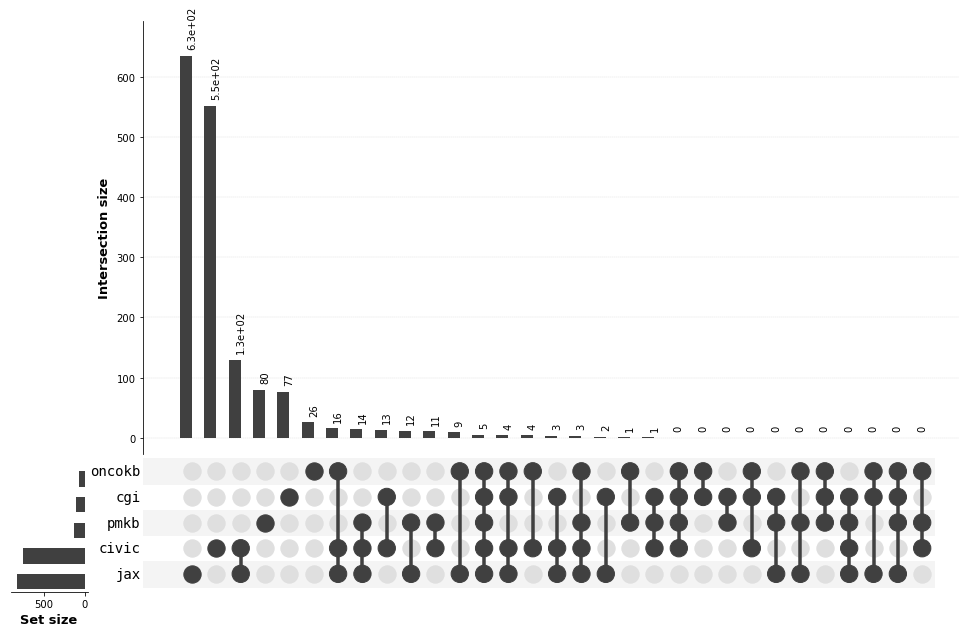

In [146]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g]), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = column_names)
    
plot_overlap(success_by_source, column_names=['gene', 'phenotype'])